# Optimize the Filter and Threshold maximize the Correlation between the Bore Speed and the Jump Speed when choosing how to pick out the jumps

In [48]:
import cftime
from datetime import timedelta
from datetime import datetime
import glob
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy import signal
from scipy import stats
from scipy import optimize
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import mission_tools

%matplotlib widget

In [50]:
# Functions to Find all Jumps
def extract_jump_inds(jump_inds, consecutive_values=1):
    event_inds = np.where(jump_inds == 1)[0]
    event_groups = np.split(event_inds, np.where(np.diff(event_inds) != consecutive_values)[0]+1)
    return event_groups

def extract_jumps(filter_cutoff, phase_speed_threshold):
    mission_list = glob.glob('../../microSWIFT_data/final_dataset/mission_*.nc')

    mission_number = []
    jump_amps_all_missions = []
    jump_seconds_all_missions = []
    jump_depth_all_missions = []
    mission_number_for_event = []
    trajectory_number_for_event = []
    xdist_for_event = []
    ydist_for_event = []
    depth_for_event = []

    for mission_nc in mission_list:
        mission_dataset = nc.Dataset(mission_nc, mode='r')

        x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
        y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])
        time = cftime.num2pydate(mission_dataset['time'],
                                    units=mission_dataset['time'].units,
                                    calendar=mission_dataset['time'].calendar)

        number_of_trajectories = x_locations.shape[0]

        mission_num = int(mission_nc[44:-3])
        mission_number.append(mission_num)
        # Add mean water level 
        mission_df = pd.read_csv('../../microSWIFT_data/mission_df.csv')
        mission_df_sorted = mission_df.sort_values(by=['mission number'])
        water_level = mission_df_sorted[mission_df_sorted['mission number'] == mission_num]['water level [m]'].values[0]
        jump_amps_each_mission = []
        jump_seconds_each_mission = []
        jump_depth_each_mission = []

        for trajectory_num in np.arange(number_of_trajectories):

            # Compute Cross Shore Velocity from Cross Shore Position
            cross_shore_vel = np.gradient((x_locations[trajectory_num,0] - x_locations[trajectory_num,:]), 1/12)
            cross_shore_vel = np.ma.filled(cross_shore_vel, np.NaN)
            sos = signal.butter(1, filter_cutoff, 'lowpass', fs=12, output='sos')
            cross_shore_vel_nonans = cross_shore_vel.copy()
            cross_shore_vel_nonans[np.isnan(cross_shore_vel)] = 0
            cross_shore_vel_filtered = signal.sosfiltfilt(sos, cross_shore_vel_nonans)
            cross_shore_vel_filtered[np.isnan(cross_shore_vel)] = np.NaN

            # Depth Along Trajectory
            bathy_file_path = '../../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
            trajectory_bathy = mission_tools.bathy_along_track(bathy_file=bathy_file_path, 
                                                                xFRF=x_locations[trajectory_num, :], 
                                                                yFRF=y_locations[trajectory_num, :],
                                                                single_trajectory=True)[0]
            trajectory_depth = trajectory_bathy + water_level

            # Compute Linear Phase Speed at each point in track
            phase_speed_along_track = np.sqrt(np.abs(trajectory_depth * 9.8))

            # Find all times that the cross shore velocity is higher than the threshold
            jump_threshold = phase_speed_along_track * phase_speed_threshold
            jump_times = np.zeros(cross_shore_vel_filtered.size)
            jump_inds = np.where(cross_shore_vel_filtered > jump_threshold)
            jump_times[jump_inds] = 1

            # Get the jump Indices
            jump_event_inds = extract_jump_inds(jump_times, consecutive_values=1)

            for event in jump_event_inds:
                if event.size > 0:
                    jump_amp = np.sqrt((x_locations[trajectory_num,event[-1]] - x_locations[trajectory_num,event[0]])**2 +
                                    (y_locations[trajectory_num,event[-1]] - y_locations[trajectory_num,event[0]])**2 )
                    xdist_for_event.append(x_locations[trajectory_num,event[0]:event[-1]].filled(np.NaN))
                    ydist_for_event.append(y_locations[trajectory_num,event[0]:event[-1]].filled(np.NaN))
                    depth_for_event.append(trajectory_depth[event[0]:event[-1]])
                    jump_amps_each_mission.append(jump_amp)
                    jump_seconds_each_mission.append((time[event[-1]] - time[event[0]]).total_seconds())
                    jump_depth_each_mission.append(np.abs(np.mean([trajectory_depth[event[0]:event[-1]]])))
                    mission_number_for_event.append(mission_num)
                    trajectory_number_for_event.append(trajectory_num)

        # save each mission
        jump_amps_all_missions.append(jump_amps_each_mission)
        jump_seconds_all_missions.append(jump_seconds_each_mission)
        jump_depth_all_missions.append(jump_depth_each_mission)

    # flatten and concatenate each distribution
    jump_amps_all_missions_flat = np.ma.concatenate(jump_amps_all_missions).flatten()
    jump_seconds_all_missions_flat = np.ma.concatenate(jump_seconds_all_missions).flatten()
    jump_depth_all_missions_flat = np.ma.concatenate(jump_depth_all_missions).flatten()

    # Remove all points where depth is 1 meter or less (Bathymetry changes often)
    depth_outlier_inds = np.where(jump_depth_all_missions_flat < 0.75)[0]
    # remove jumps less than 5 meters (Accuracy of GPS is 3 meters)
    amp_outlier_inds = np.where(jump_amps_all_missions_flat < 5)[0]
    # Remove Short Jumps (a jump shorter than this may be misleading)
    time_outlier_inds = np.where(jump_seconds_all_missions_flat < 5)[0]

    # Outlier indices and removing them from each 
    outlier_inds = np.unique(np.append(np.append(depth_outlier_inds, amp_outlier_inds), time_outlier_inds))

    jump_depth_all_missions_flat_clean = np.delete(jump_depth_all_missions_flat, outlier_inds)
    jump_amps_all_missions_flat_clean = np.delete(jump_amps_all_missions_flat, outlier_inds)
    jump_seconds_all_missions_flat_clean = np.delete(jump_seconds_all_missions_flat, outlier_inds)
    
    # Compute Speed of jump and phase Speed
    phase_speed_each_jump = np.sqrt(9.8 * jump_depth_all_missions_flat_clean)
    avg_speed_each_jump = jump_amps_all_missions_flat_clean / jump_seconds_all_missions_flat_clean
    
    return avg_speed_each_jump, phase_speed_each_jump

# Compute the linear regression between the linear phase speed and the jump speed and the difference from 1
def speed_regression_diff_minimization(filter_cutoff, phase_speed_threshold=0.3):
    avg_speed_each_jump, \
    phase_speed_each_jump = extract_jumps(filter_cutoff, phase_speed_threshold)
    try:
        slope, \
        intercept, \
        r_value, \
        p_value, \
        std_err= stats.linregress(avg_speed_each_jump, phase_speed_each_jump)

        slope_diff = np.abs(1-slope)
        print(f'Slope diff is {slope_diff}')
        print(f'Slope is {slope}')

    except:
        print(f'Could Not Compute regression with filter cutoff of {filter_cutoff} and threshold of {phase_speed_threshold}')
        slope_diff = 1
        slope = 0 

    return slope_diff, slope


In [27]:
# # Optimize the Slope of the regression between the phase speed and the jump speed
# initial_guess = 0.1
# optimized_result = optimize.differential_evolution(speed_regression_diff_minimization, bounds=[(0.01, 6)], tol=0.1)

In [28]:
# # Print the Optimized Result and apply it to the data
# print(optimized_result)


In [36]:
slope_diff, slope = speed_regression_diff_minimization(0.1, 0.3)
print(slope)
print(slope_diff)

/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean

0.4136708519953576
0.5863291480046424


Now Vary the Optimization as a function of phase speed threshold to determine the best fit for this data. 

In [54]:
threshold_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
filter_cutoff_values = [0.01, 0.05, 0.1, 0.5, 1, 5]

regression_slope_values_each_filter = []
for n in range(len(filter_cutoff_values)):
    print(f'Filter Value: {filter_cutoff_values[n]}')
    regression_slope_values_each_threshold = []

    for i in range(len(threshold_values)):
        print(f'Threshold Value: {threshold_values[i]}')
        slope_diff, slope = speed_regression_diff_minimization(filter_cutoff_values[n], threshold_values[i])
        regression_slope_values_each_threshold.append(slope)
    
    regression_slope_values_each_filter.append(regression_slope_values_each_threshold)



Filter Value: 0.01
Threshold Value: 0.1
Slope diff is 0.5062812114160642
Slope is 0.4937187885839358
Threshold Value: 0.2
Slope diff is 0.5333769213277634
Slope is 0.4666230786722366
Threshold Value: 0.3
Slope diff is 0.8185266823252098
Slope is 0.18147331767479027
Threshold Value: 0.4
Slope diff is 0.8817016635953604
Slope is 0.11829833640463958
Threshold Value: 0.5
Slope diff is 0.9133786741008021
Slope is 0.08662132589919791
Threshold Value: 0.6
Slope diff is 0.9729578801290426
Slope is 0.027042119870957365
Threshold Value: 0.7
Could Not Compute regression with filter cutoff of 0.01 and threshold of 0.7
Threshold Value: 0.8
Could Not Compute regression with filter cutoff of 0.01 and threshold of 0.8
Threshold Value: 0.9
Could Not Compute regression with filter cutoff of 0.01 and threshold of 0.9
Threshold Value: 1
Could Not Compute regression with filter cutoff of 0.01 and threshold of 1
Filter Value: 0.05
Threshold Value: 0.1
Slope diff is 0.6628078331500978
Slope is 0.337192166849

In [55]:
# Save to a file 
file = open('regression_slope_optimization_results.txt','w')
for n in range(len(regression_slope_values_each_filter)):
    file.write("/n")
    for i in range(len(regression_slope_values_each_filter[n])):
	    file.write(str(regression_slope_values_each_filter[n][i])+",")
file.close()


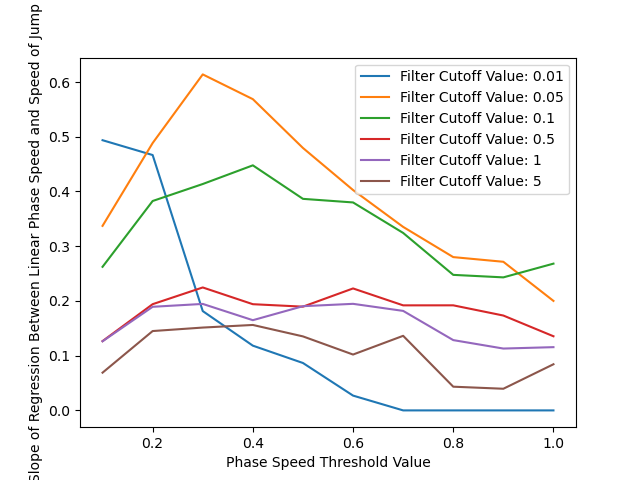

In [63]:
fig, ax = plt.subplots()
for n in range(len(filter_cutoff_values)):
    ax.plot(threshold_values, regression_slope_values_each_filter[n], label=f'Filter Cutoff Value: {filter_cutoff_values[n]}')

ax.set_xlabel('Phase Speed Threshold Value')
ax.set_ylabel('Slope of Regression Between Linear Phase Speed and Speed of Jump')
ax.legend()

Based on this analysis, it looks like the best filter and threshold design is a Filter cutoff of 0.05 and a threshold value of 0.3 phase speed.

In [ ]:
# Use the optimal Filter and threshold Design to look at the jumps
avg_speed_each_jump, \
phase_speed_each_jump = extract_jumps(filter_cutoff=0.05, phase_speed_threshold=0.3)

slope, \
intercept, \
r_value, \
p_value, \
std_err= stats.linregress(avg_speed_each_jump, phase_speed_each_jump)

fig, ax = plt.subplots()
ax.scatter(avg_speed_each_jump, phase_speed_each_jump)
ax.set_xlabel('Avg Speed of Jump [m/s]')
ax.set_label('Linear Phase Speed [m/s]')